In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import random
import math
from tqdm import tqdm

# Задание:
Разработать скрипт, который будет с адекватным качеством классифицировать тексты по стилю (“разговорный”, “техническая литература”, “художественная литература”). 
(качество может быть ограничено лимитированным временем).
Обучающий датасет не предоставляется.

# Данные

### Разговорная речь

В качестве примеров разговорной речи я взял твиты отсюда https://www.kaggle.com/kazanova/sentiment140?select=training.1600000.processed.noemoticon.csv

В каждом твите убрал знаки препинания, лишние пробелы и сделал все буквы строчными

In [2]:
data_1 = pd.read_csv('tweets.csv', encoding='ISO-8859-1', names=[1, 2, 3, 4, 5, 'text'])
data_1['target'] = np.zeros(len(data_1))
data_1 = data_1[['text', 'target']]
data_1['text'] = data_1.apply(lambda x: x[0].translate(str.maketrans('', '', string.punctuation)).lower(), axis=1)
data_1.head()

,text,target
0,switchfoot httptwitpiccom2y1zl awww thats a b...,0.0
1,is upset that he cant update his facebook by t...,0.0
2,kenichan i dived many times for the ball manag...,0.0
3,my whole body feels itchy and like its on fire,0.0
4,nationwideclass no its not behaving at all im ...,0.0


Давайте посмотрим на распределение длин получившихся строк

(array([ 459., 1211., 1392., 1451., 1253., 1128.,  939.,  826., 1092.,
         249.]),
 array([  5. ,  19.2,  33.4,  47.6,  61.8,  76. ,  90.2, 104.4, 118.6,
        132.8, 147. ]),
 <a list of 10 Patch objects>)

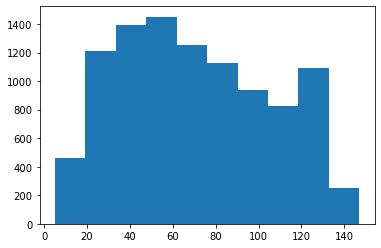

In [3]:
plt.hist(data_1[:10000].apply(lambda x: len(x[0]), axis=1))

### Художественная литература

В качестве примеров художественной литературы я взял три книги: "Великий Гэтсби", "Старик и море" и "1984" 

In [4]:
def remove_punctuation(a):
    black_symbols = ''.join([chr(num) for num in range(32)]) + string.punctuation + '”“’…—'
    res = a.translate(str.maketrans('', '', black_symbols)).lower()
    res = res.replace('\n', ' ').replace('section', ' ').replace('chapter', ' ')
    return res

Аналогично уберём знаки препинания, лишние пробелы и сделаем все буквы строчными

In [5]:
tmp1 = remove_punctuation(open("The-Great-Gatsby.txt", "r").read())
tmp2 = remove_punctuation(open("old_man.txt", "r").read())
tmp3 = remove_punctuation(open("1984.txt", "r").read())

Из каждой книги извлечём случайные подстроки от 20 до 150 символов (чтобы длина была как у твитов)

In [6]:
def get_random_substring(a):
    left = random.randint(0, len(a))
    right = left + random.randint(20, 150)
    return a[left:right]

In [7]:
data_2 = []
for _ in range(int(5e5)):
    data_2.append([get_random_substring(tmp1), 1])
    data_2.append([get_random_substring(tmp2), 1])
    data_2.append([get_random_substring(tmp3), 1])

In [8]:
data_2 = pd.DataFrame(data_2, columns=['text', 'target'])
data_2.head()

,text,target
0,he tiredand daisy ought to have something in h...,1
1,s jaws were working convulsively in quick bite...,1
2,with a rubber club the next moment however the...,1
3,t she looked at me with an absolute smirk on h...,1
4,o know that this had truly happened and was no...,1


### Техническая литература

В качестве примеров технической литературы я взял отрывки из кормена и учебника по графам

In [9]:
tmp1 = remove_punctuation(open("Introduction to Algorithms, Third Edition.txt", "r").read())
tmp2 = remove_punctuation(open("GT_Bondy_Murty_3.txt", "r").read())

И проделал то же самое, что и с художественной литературой

In [10]:
data_3 = []
for _ in range(int(8e5)):
    data_3.append([get_random_substring(tmp1), 2])
    data_3.append([get_random_substring(tmp2), 2])

In [11]:
data_3 = pd.DataFrame(data_3, columns=['text', 'target'])
data_3.head()

,text,target
0,entication tag t d hm and bob checks that the ...,2
1,− 1 edgedisjoint segments bythe pigeonhole pr...,2
2,e the time required to perform a sequence ofda...,2
3,upergraphs41all other subgraphs f and supergra...,2
4,of this book we shall assume a generic onepro...,2


In [12]:
data = pd.concat([data_1, data_2, data_3])
data.head()

,text,target
0,switchfoot httptwitpiccom2y1zl awww thats a b...,0.0
1,is upset that he cant update his facebook by t...,0.0
2,kenichan i dived many times for the ball manag...,0.0
3,my whole body feels itchy and like its on fire,0.0
4,nationwideclass no its not behaving at all im ...,0.0


В итоге мы собрали датасет с текстами длиной от 20 до 150, причём все классы представленны в одинаковом количестве

# Модель

### Препроцессинг

Разделим все наши данные на обучающую и тестовую выборки. Так как данных получилось слишком много, возьмём только часть для дальнейшей работы

In [13]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

#
data_train = data_train[:10000]
data_val = data_val[:5000]

Сделаем так, чтобы каждый текст представлял из себя токены разделённые пробелом

In [14]:
import nltk
from collections import Counter

tokenizer = nltk.tokenize.WordPunctTokenizer()
token_counts = Counter()

In [15]:
data_train['text'] = data_train.apply(lambda x: ' '.join(tokenizer.tokenize(x[0])), axis=1)

Теперь посмотрим сколько раз встречается каждый токен в нашем корпусе

In [16]:
for sentence in data_train['text']:
    token_counts.update(sentence.split())

In [17]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-5:])))

Total unique tokens : 22275
('the', 7057)
('a', 3890)
('of', 3684)
('and', 3349)
('to', 2989)
...
('sigourney', 1)
('howard', 1)
('hurrying', 1)
('talkedher', 1)
('waved', 1)


Text(0.5, 0, 'Counts')

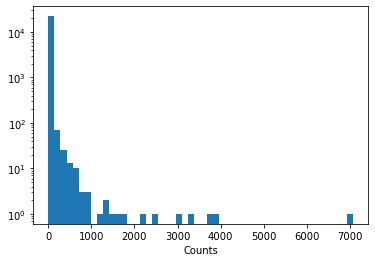

In [18]:
_ = plt.hist(list(token_counts.values()), bins=50, log=True)
plt.xlabel("Counts")

Мы не хотим учитывать опечатки и редкие слова, поэтому оставим только токены, которы встречаются > 10 раз

In [19]:
stop_tokens = [key for key, value in token_counts.items() if value < 10]

Для всех остальных токенов посчитаем $tf-idf$. Таким образом для каждого текста получили векторное представление

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stop_tokens)
x_train = vectorizer.fit_transform(data_train['text'])
x_train = np.array(x_train.todense())
print(x_train.shape)

(10000, 1529)


In [21]:
y_train = data_train['target'].values

In [22]:
data_val['text'] = data_val.apply(lambda x: ' '.join(tokenizer.tokenize(x[0])), axis=1)
x_val = vectorizer.transform(data_val['text'])
x_val = np.array(x_val.todense())
y_val = data_val['target'].values

### Обучение модели

In [23]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
def get_batch(data_x, data_y, size):
    '''
    Возвращает случайный батч размера size
    '''
    assert (len(data_x) == len(data_y))
    sample = np.random.choice(len(data_x), size)
    x0 = torch.tensor(data_x[sample][:, None, :], dtype=torch.float32)
    y0 = torch.tensor(data_y[sample], dtype=torch.long)
    
    return x0, y0

In [31]:
def get_accuracy(y_true, y_pred):
    '''
    Считает accuracy
    '''
    y_true = y_true.detach().numpy()
    y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
    
    return (y_true == y_pred).mean()

В качестве модели выберем нейронную сеть с 4 скрытыми слоями. На вход она получает векторное представление текста, а на выходе вектор из трёх чисел: $[\ln(p_1), ~ \ln(p_2), ~ \ln(p_3)]$, где $p_i$ - вероятность, что текст принадлежит соответствующему стилю

In [26]:
class Model(nn.Module):
    def __init__(self, tokens_len):
        super(self.__class__, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(5, 20, kernel_size=5, padding=1)
        
        self.batchnorm1 = nn.BatchNorm1d(5)
        self.dropout1 = nn.Dropout(0.5)
        
        tmp = math.floor(((tokens_len - 2) / 2 - 3) / 2 + 1)
        self.dense1 = nn.Linear(20 * tmp, 1000)
        self.dense2 = nn.Linear(1000, 50)
        
        self.batchnorm2 = nn.BatchNorm1d(50)
        self.dropout2 = nn.Dropout(0.5)
        
        self.dense3 = nn.Linear(50, 3)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.max_pool1d(x, 2, 2)
        
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = F.max_pool1d(x, 2, 2)
        
        x = x.view(-1, x.shape[1] * x.shape[2])
        
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.dense3(x))
        
        return self.softmax(x)

In [27]:
model = Model(x_train.shape[1])
model

Model(
  (conv1): Conv1d(1, 5, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(5, 20, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=7620, out_features=1000, bias=True)
  (dense2): Linear(in_features=1000, out_features=50, bias=True)
  (batchnorm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=50, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

В качестве loss-функции возьмём $CrossEntropy$, а в качестве финальной метрики $Accuracy$

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

Начнём само обучение:

In [32]:
for epoch in tqdm(range(10)):
    
    train_loss = 0
    train_acc = 0
    
    train_batches = int(len(x_train) / 100)
    
    #optimize model on all train batches
    for _ in range(train_batches):
        optimizer.zero_grad() 
        
        inp, out = get_batch(x_train, y_train, 100)
        pred = model.forward(inp)

        loss = criterion(pred, out)
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
        train_acc += get_accuracy(out, pred)
    
    # save loss and accuracy on train dataset
    train_loss_hist.append(train_loss / train_batches)
    train_acc_hist.append(train_acc / train_batches)
    
    
    # calculate loss and accuracy on test dataset
    inp, out = get_batch(x_val, y_val, len(x_val))
    pred = model.forward(inp)
    
    test_loss = float(criterion(pred, out))
    test_acc = get_accuracy(out, pred)
    
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)

100%|██████████| 10/10 [02:31<00:00, 15.18s/it]


Давайте посмотрим на процесс обучение

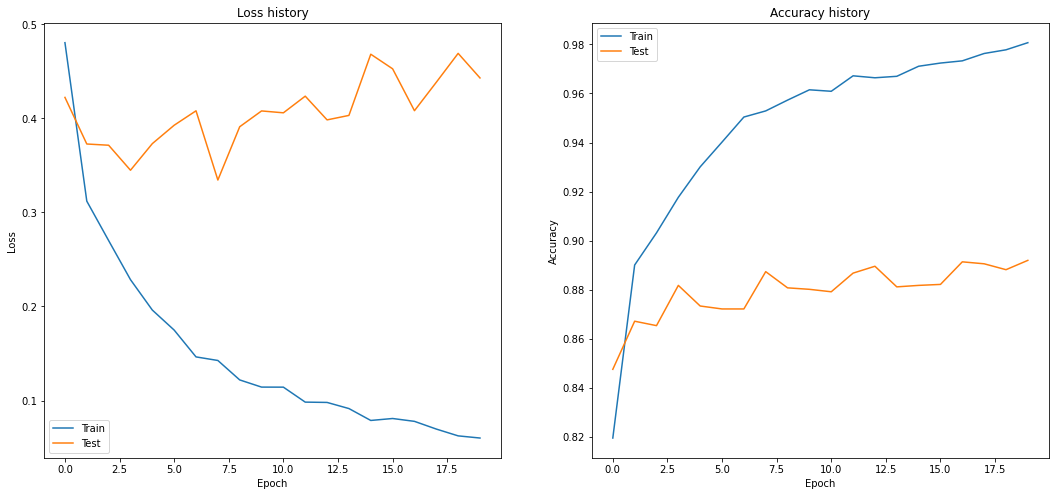

In [33]:
plt.figure(figsize=(18, 8))

plt.subplot(121)
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.legend()

plt.subplot(122)
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc_hist, label='Train')
plt.plot(test_acc_hist, label='Test')
plt.legend()

Почему-то loss на тесте не падает. Возможно это вызвано тем, что токены на трейне и тесте отличаются.

При этом accuracy медленно, но верно растёт. И даже за одну эпоху очень хороший уровень качества

### Accuracy на тестовой выборке

In [35]:
inp, out = get_batch(x_val, y_val, len(x_val))
pred = model.forward(inp)
get_accuracy(out, pred)

0.8832

### Save model

In [36]:
torch.save(model, 'MODEL')

In [37]:
import pickle

pickle.dump(vectorizer, open("tfidf.pickle", "wb"))